In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, holidays
#import xgboost as xgb
from darts.models import NaiveSeasonal
from darts.models import RandomForest
from darts import TimeSeries
from statsmodels.graphics.tsaplots import plot_pacf
# from sklearn.metrics import mean_absolute_percentage_error as mape, root_mean_squared_error as rmse, mean_absolute_error as mae
from darts.metrics import mape, mae, rmse
from sklearn.model_selection import RandomizedSearchCV
from datetime import timedelta

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 22})

In [8]:
def print_evaluation_metrics(actual,predicted):
    
    # Compute MAPE
    actual_series = TimeSeries.from_series(actual)
    predicted_series = TimeSeries.from_series(predicted)

    mape_val = mape(actual_series, predicted_series)
    rmse_val = rmse(actual_series, predicted_series)
    mae_val = mae(actual_series, predicted_series)

    print(f"MAPE: {mape_val:.2f}%")
    print(f"RMSE: {rmse_val:.2f}")
    print(f"MAE: {mae_val:.2f}MW")

    # Combine into one DataFrame
    df = pd.DataFrame({
        'actual': actual,
        'predicted': predicted
    })
    df.index = pd.to_datetime(df.index)  # Ensure datetime index

    # Remove rows where actual == 0 to avoid division by zero
    df = df[df['actual'] != 0]

    # Add 'date' column for grouping
    df['date'] = df.index.date

    # Calculate absolute percentage error per row
    df['abs_pct_error'] = np.abs(df['actual'] - df['predicted']) / df['actual']

    # Group by date and calculate daily MAPE
    daily_mape = df.groupby('date')['abs_pct_error'].mean() * 100  # Convert to %

    max_mape_value = daily_mape.max()
    min_mape_value = daily_mape.min()
    max_mape_date = daily_mape.idxmax()
    min_mape_date = daily_mape.idxmin()

    print(f"Maximum MAPE: {max_mape_value:.2f}% on {max_mape_date}")
    print(f"Minimum MAPE: {min_mape_value:.2f}% on {min_mape_date}")
    
def plot_forecast(actual, predicted, model, model_name, xgb_feat=False):
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual, label='Actual', linewidth=2)
    plt.plot(predicted.index, predicted, label='Predicted')#linestyle='--'
    #plt.xticks(rotation=45)
    plt.legend()
    plt.title('Load Forecast: Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Load (MW)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(model_name, format="pdf", bbox_inches="tight")
    plt.show()

    # Feature Importance Plot
    if xgb_feat:
        xgb.plot_importance(model, height=0.6, max_num_features=50)
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()

In [9]:
def read_load_data():
    base_dir = os.getcwd()
    load_file_path = os.path.join(base_dir, 'processed_loadUTC_data.csv')
    load_data = pd.read_csv(load_file_path)
    load_data.rename(columns={
        "Actual Total Load [MW] - BZN|SE4": "Actual Load",
        "Time (UTC)": "Time"
    }, inplace=True)
    load_data['Time'] = pd.to_datetime(load_data['Time'].str.split(' - ').str[0], format='%d.%m.%Y %H:%M')
    load_data.set_index('Time', inplace=True)
    load_data.drop('Day-ahead Total Load Forecast [MW] - BZN|SE4', axis=1, inplace=True)
    return load_data

data = read_load_data()

MAPE: 8.39%
RMSE: 296.98
MAE: 206.07MW
Maximum MAPE: 42.34% on 2024-11-26
Minimum MAPE: 2.54% on 2024-07-01


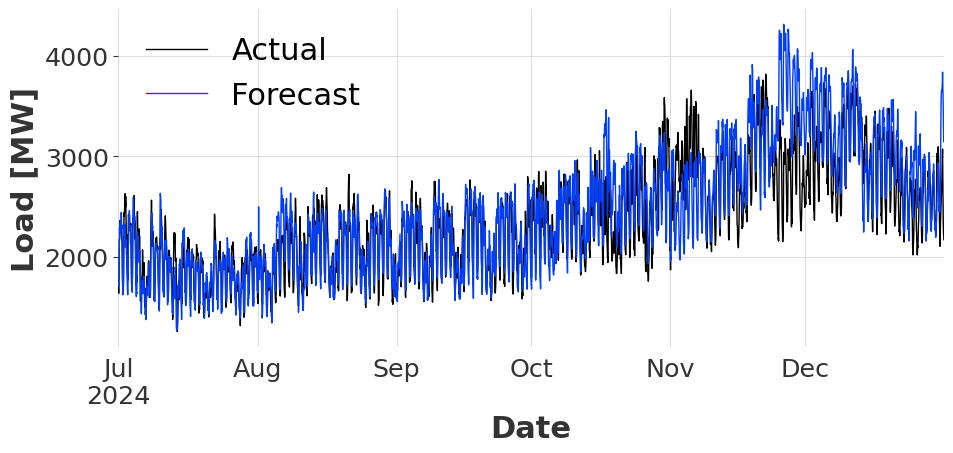

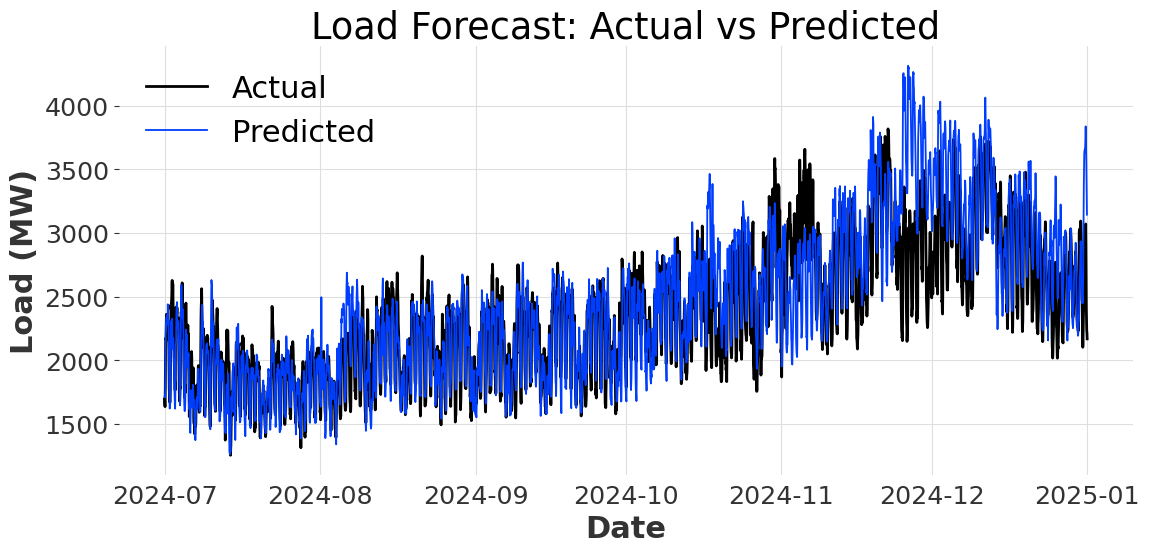

In [10]:
# Load data
forecast_data = data['Actual Load']
series = TimeSeries.from_series(forecast_data)

# Define target forecast length (e.g. one year = 366 days)
full_hours = 24 * 366  # 8784 hours

# Make sure test set ends on final timestamp
test_end = series.end_time()

# Adjust start so that the time window is a multiple of 168 (full weeks)
hours_to_trim = full_hours % 168  # remove excess to get full weeks only
test_start = test_end - timedelta(hours=(full_hours - hours_to_trim) - 1)

# Create actual and training sets
actual = series.slice(test_start, test_end)
train = series.drop_after(test_start - timedelta(hours=1))

# Fit model
model = NaiveSeasonal(K=len(actual))
model.fit(train)

# Forecast for the same length as the actual set
forecast = model.predict(len(actual))

# Convert to pandas Series
actual_pd = actual.to_series()
forecast_pd = forecast.to_series()
actual_pd = actual_pd['2024-07-01':'2024-12-31']
forecast_pd = forecast_pd['2024-07-01':'2024-12-31']

print_evaluation_metrics(actual_pd,forecast_pd)

# Plot
plt.figure(figsize=(10, 5))
actual_pd.plot(label='Actual', lw=1)
forecast_pd.plot(label='Forecast', lw=1)
#plt.xticks(rotation=45)
plt.legend()
#plt.title("Forecast vs Actual (Trimmed to Full Weeks Ending Dec 31)")
plt.xlabel("Date")
plt.ylabel("Load [MW]")
plt.grid(True)
plt.tight_layout()
plt.savefig("NSM.pdf", format="pdf", bbox_inches="tight")
plt.show()

plot_forecast(actual_pd,forecast_pd,model, "NSM.pdf")

In [11]:
print(train.time_index)

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2024-01-02 13:00:00', '2024-01-02 14:00:00',
               '2024-01-02 15:00:00', '2024-01-02 16:00:00',
               '2024-01-02 17:00:00', '2024-01-02 18:00:00',
               '2024-01-02 19:00:00', '2024-01-02 20:00:00',
               '2024-01-02 21:00:00', '2024-01-02 22:00:00'],
              dtype='datetime64[ns]', name='Time', length=78935, freq='h')


In [12]:
print(type(forecast),type(actual))

<class 'darts.timeseries.TimeSeries'> <class 'darts.timeseries.TimeSeries'>


In [13]:
def import_weather_data(df, solar_power=False):
    base_dir = os.getcwd()
    temperature_file_path = os.path.join(base_dir, 'weighted_avg_temp.csv')
    humidity_file_path = os.path.join(base_dir, 'weighted_avg_humidity.csv')
    solar_file_path = os.path.join(base_dir, 'weighted_avg_solar.csv')
    avg_temperature_data = pd.read_csv(temperature_file_path)
    avg_humidity_data = pd.read_csv(humidity_file_path)
    avg_solar_data = pd.read_csv(solar_file_path)
    df['Temperature'] = avg_temperature_data['weighted_avg'].values
    df['Humidity'] = avg_humidity_data['weighted_avg'].values
    df['Solar_Irrad'] = avg_solar_data['weighted_avg'].values
    
    if solar_power:
        tot_installed_capacity = np.array([2.52, 5.04, 7.56, 10.08, 12.6, 18.6, 29.2, 41.53, 69.55, 85])*1e6
        installed_capacity_house = 10*1e3
        n_installations = tot_installed_capacity / installed_capacity_house
        panel_per_house = 24
        area_per_panel = 2

        years = np.arange(2015, 2025)
        total_area_panels = n_installations * panel_per_house * area_per_panel
        area_by_year = dict(zip(years, total_area_panels))

        panel_efficiency = 0.2
        df['year'] = df.index.year
        df['Solar'] = df['Solar_Irrad'] * data['year'].map(area_by_year) * panel_efficiency
        df.drop(columns='year', inplace=True)
    else:
        df['Solar'] = df['Solar_Irrad']
    df.drop(columns='Solar_Irrad',inplace=True)
    return df

data = import_weather_data(data, solar_power=True)

In [14]:
def import_swedish_holidays(df):
    years = np.arange(2015, 2025)
    raw_holidays = []
    for date, name in sorted(holidays.Sweden(years=years).items()):
        if not name == "Söndag":
            raw_holidays.append(date)
        raw_holidays.append(date)
    holiday_dates = set(raw_holidays)
    df['is_holiday'] = pd.Series(df.index.date).isin(holiday_dates).astype(int).values
    return df

data = import_swedish_holidays(data)

In [15]:
def create_date_features(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    return df

data = create_date_features(data)

In [127]:
def add_noise_to_covariates(df, noise_level: float = 0.05):
    stochastic_cols = ["Temperature", "Humidity",  "Solar"]#
    df_noisy = df.copy()

    for col in stochastic_cols:
        if col in df_noisy.columns:
            if col == "Solar":
                # Proportional noise based on value (avoid large noise when value is 0)
                base = df_noisy[col].values
                noise = np.random.normal(0, noise_level * base)
                df_noisy[col] += noise
                df_noisy[col] = df_noisy[col].clip(lower=0)  # Prevent negative solar
            else:
                # Standard deviation-based noise
                std = df_noisy[col].std()
                noise = np.random.normal(0, noise_level * std, size=len(df_noisy))
                df_noisy[col] += noise

    return df_noisy


future_data = add_noise_to_covariates(data)

In [128]:
data['past_load'] = data['Actual Load']

split_dates = ['2023-12-31', '2024-06-30', '2024-12-31', '2022-01-01']  

train = data[split_dates[3]:split_dates[1]]  
valid = data[split_dates[0]:split_dates[1]]  
test = data[split_dates[1]:split_dates[2]]  

valid_future = future_data[split_dates[0]:split_dates[1]]  
test_future = future_data[split_dates[1]:split_dates[2]]  

target_column = 'Actual Load'

# Convert to Darts TimeSeries objects with explicit frequency 'h' (hourly)
train_series = TimeSeries.from_dataframe(train, value_cols=target_column, freq='h')
valid_series = TimeSeries.from_dataframe(valid, value_cols=target_column, freq='h')
test_series = TimeSeries.from_dataframe(test, value_cols=target_column, freq='h')

# Prepare covariates
feature_columns_past = ['Temperature', 'Humidity', 'Solar', 'is_holiday', 'hour', 'dayofweek', 'is_weekend', 'past_load']
train_covariates_past = TimeSeries.from_dataframe(train, value_cols=feature_columns_past, freq='h')
valid_covariates_past = TimeSeries.from_dataframe(valid, value_cols=feature_columns_past, freq='h')
test_covariates_past = TimeSeries.from_dataframe(test, value_cols=feature_columns_past, freq='h')

feature_columns_future = ['Temperature', 'Humidity', 'Solar', 'is_holiday', 'hour', 'dayofweek', 'is_weekend']
train_covariates_future = TimeSeries.from_dataframe(train, value_cols=feature_columns_future, freq='h')
valid_covariates_future = TimeSeries.from_dataframe(valid_future, value_cols=feature_columns_future, freq='h')
test_covariates_future = TimeSeries.from_dataframe(test_future, value_cols=feature_columns_future, freq='h')

In [129]:
# Create model
model = RandomForest(n_estimators=400,
                     max_depth=20,
                     lags=[-1, -2, -3, -6, -12, -24],
                     lags_past_covariates={'Temperature': [-1, -3, -6, -12, -24],
                                           'Solar': [-1, -3, -6],
                                           'Humidity': [-1, -3, -6, -12],
                                           'past_load': [-24, -48, -72, -96, -120, -144, -168],
                                           'is_holiday': [-1, -2, -3, -24],
                                           'hour': [-1, -2, -3, -24],
                                           'dayofweek': [-1, -2, -3, -24],
                                           'is_weekend': [-1, -2, -3, -24]},
                     lags_future_covariates=list(range(25)),
                     output_chunk_length=24,                     
                     n_jobs=-1,
                     criterion='squared_error')    

model.fit(series=train_series,
          past_covariates=train_covariates_past,         
          future_covariates=train_covariates_future)

RandomForest(lags=[-1, -2, -3, -6, -12, -24], lags_past_covariates={'Temperature': [-1, -3, -6, -12, -24], 'Solar': [-1, -3, -6], 'Humidity': [-1, -3, -6, -12], 'past_load': [-24, -48, -72, -96, -120, -144, -168], 'is_holiday': [-1, -2, -3, -24], 'hour': [-1, -2, -3, -24], 'dayofweek': [-1, -2, -3, -24], 'is_weekend': [-1, -2, -3, -24]}, lags_future_covariates=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], output_chunk_length=24, output_chunk_shift=0, add_encoders=None, n_estimators=400, max_depth=20, multi_models=True, use_static_covariates=True, n_jobs=-1, criterion=squared_error)

In [133]:
model_no_cov = RandomForest(n_estimators=400,
                            max_depth=20,
                            lags = [-1, -2, -3, -6, -12, -24],
                            output_chunk_length=24,
                            n_jobs=-1,
                            criterion='squared_error')

model_no_cov.fit(series=train_series)

RandomForest(lags=[-1, -2, -3, -6, -12, -24], lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=24, output_chunk_shift=0, add_encoders=None, n_estimators=400, max_depth=20, multi_models=True, use_static_covariates=True, n_jobs=-1, criterion=squared_error)

In [ ]:
forecast_intervals = ['2024-07-08', '2024-07-22', '2024-10-14', '2024-10-28', '2024-12-02', '2024-12-23']  

start_date = pd.Timestamp("2024-10-14 00:00:00")
forecast_horizon = 7 * 24  

# Provide the prediction with a time series up until the prediction start
history_until = test_series.drop_after(start_date - pd.Timedelta(hours=1))

# Start time for covariate series
required_start = start_date - pd.Timedelta(hours=169)

# Slice covariates 
past_cov_start = start_date - pd.Timedelta(hours=169)
past_cov_end = start_date + pd.Timedelta(hours=forecast_horizon - 1)

past_cov_slice = test_covariates_past.slice(past_cov_start, past_cov_end)

future_cov_start = start_date - pd.Timedelta(hours=1)
future_cov_end = start_date + pd.Timedelta(hours=forecast_horizon - 1 + 24)

future_cov_slice = test_covariates_future.slice(future_cov_start, future_cov_end)

#forecast = model.predict(n=forecast_horizon,
#                         series=history_until,
#                         past_covariates=past_cov_slice,
#                         future_covariates=future_cov_slice)

forecast_hist = model.historical_forecasts(
    series=test_series,  
    past_covariates=test_covariates_past,
    future_covariates=test_covariates_future,
    start=start_date,
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon,  
    retrain=False,  
    last_points_only=False,  
    verbose=False
)

forecast_hist_pd = forecast_hist[0].to_series()

true_values_hist = test_series.slice(start_date, start_date + pd.Timedelta(hours=forecast_horizon - 1))
true_values_hist_pd = true_values_hist.to_series()

print_evaluation_metrics(true_values_hist_pd, forecast_hist_pd)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


MAPE: 4.21%
RMSE: 125.53
MAE: 98.02MW
Maximum MAPE: 6.11% on 2024-10-16
Minimum MAPE: 2.65% on 2024-10-15


In [145]:
print(len(forecast_hist_pd))

168


In [140]:
forecast_no_cov = model_no_cov.predict(n=forecast_horizon,
                                       series=history_until)

forecast_no_cov_pd = forecast_no_cov.to_series()

true_values_no_cov = test_series.slice(start_date, start_date + pd.Timedelta(hours=forecast_horizon - 1))
true_values_no_cov_pd = true_values_no_cov.to_series()

print_evaluation_metrics(true_values_no_cov_pd, forecast_no_cov_pd)

MAPE: 7.02%
RMSE: 204.43
MAE: 166.35MW
Maximum MAPE: 10.78% on 2024-10-19
Minimum MAPE: 4.28% on 2024-10-14


In [ ]:
def make_forecast(model, test_series, test_covariates_past, test_covariates_future):
    forecast_intervals = ['2024-07-08', '2024-07-22', '2024-10-14', '2024-10-28', '2024-12-02', '2024-12-23']

    for idx, date_str in enumerate(forecast_intervals):
        start_date = pd.Timestamp(date_str + " 00:00:00")

        # Set forecast horizon: 176 days for the first one, else 7 days
        forecast_days = 176 if idx == 0 else 7
        forecast_horizon = forecast_days * 24  # in hours

        # Provide the prediction with a time series up until the prediction start
        history_until = test_series.drop_after(start_date - pd.Timedelta(hours=1))

        # Slice covariates
        past_cov_start = start_date - pd.Timedelta(hours=169)
        past_cov_end = start_date + pd.Timedelta(hours=forecast_horizon - 1)
        past_cov_slice = test_covariates_past.slice(past_cov_start, past_cov_end)

        future_cov_start = start_date - pd.Timedelta(hours=1)
        future_cov_end = start_date + pd.Timedelta(hours=forecast_horizon - 1 + 24)
        future_cov_slice = test_covariates_future.slice(future_cov_start, future_cov_end)

        # Forecast
        forecast = model.predict(n=forecast_horizon,
                                 series=history_until,
                                 past_covariates=past_cov_slice,
                                 future_covariates=future_cov_slice,
                                 show_warnings=False)
        
        true_values = test_series.slice(start_date, start_date + pd.Timedelta(hours=forecast_horizon - 1))

        # Convert TimeSeries to pandas dataframe
        forecast_pd = forecast.to_series()
        true_values_pd = true_values.to_series()
        print('Start: ', start_date)
        print_evaluation_metrics(true_values_pd, forecast_pd)
       

In [131]:
make_forecast(model, test_series, test_covariates_past, test_covariates_future)

Start:  2024-07-08 00:00:00
MAPE: 5.75%
RMSE: 198.13
MAE: 138.56MW
Maximum MAPE: 24.26% on 2024-12-25
Minimum MAPE: 1.36% on 2024-12-14
Start:  2024-07-22 00:00:00
MAPE: 4.25%
RMSE: 97.13
MAE: 75.52MW
Maximum MAPE: 6.55% on 2024-07-28
Minimum MAPE: 2.54% on 2024-07-23
Start:  2024-10-14 00:00:00
MAPE: 4.24%
RMSE: 128.77
MAE: 98.67MW
Maximum MAPE: 6.75% on 2024-10-20
Minimum MAPE: 2.35% on 2024-10-18
Start:  2024-10-28 00:00:00
MAPE: 14.64%
RMSE: 493.86
MAE: 429.38MW
Maximum MAPE: 21.39% on 2024-10-30
Minimum MAPE: 4.21% on 2024-11-01
Start:  2024-12-02 00:00:00
MAPE: 5.66%
RMSE: 201.60
MAE: 167.29MW
Maximum MAPE: 9.46% on 2024-12-08
Minimum MAPE: 2.72% on 2024-12-04
Start:  2024-12-23 00:00:00
MAPE: 10.04%
RMSE: 306.11
MAE: 247.94MW
Maximum MAPE: 19.81% on 2024-12-25
Minimum MAPE: 3.42% on 2024-12-29


In [136]:
# make_forecast(model_no_cov, test_series, test_covariates_past=False, test_covariates_future=False)

In [ ]:
true_values = test_series.slice(start_date, start_date + pd.Timedelta(hours=forecast_horizon - 1))

# Make prediction

# Convert TimeSeries to pandas dataframe
forecast_pd = forecast.to_series()
true_values_pd = true_values.to_series()

print_evaluation_metrics(true_values_pd, forecast_pd)

MAPE: 5.76%
RMSE: 198.04
MAE: 139.11MW
Maximum MAPE: 23.59% on 2024-12-25
Minimum MAPE: 1.72% on 2024-12-14


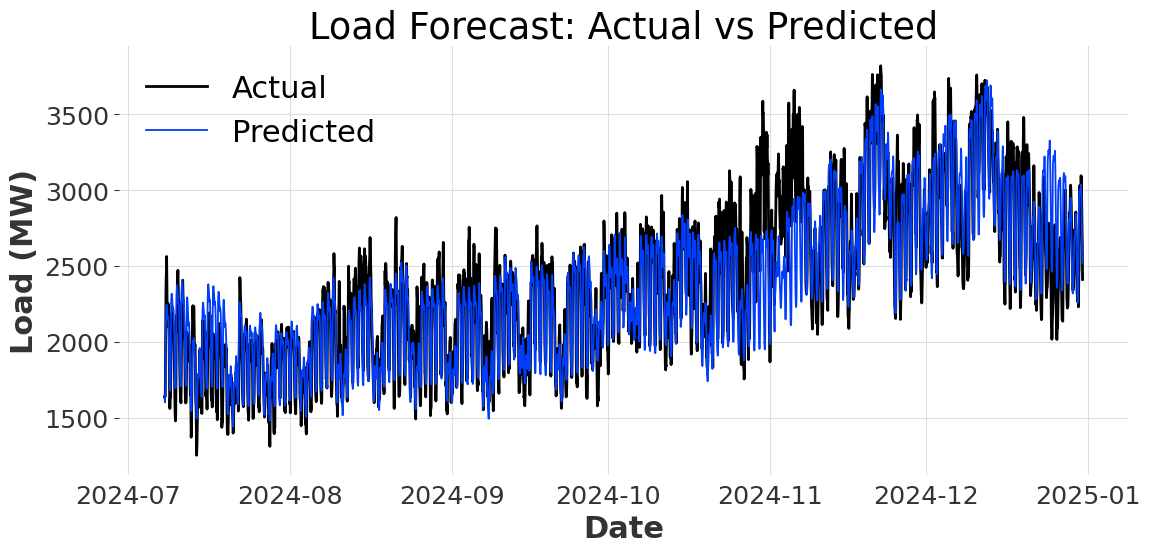

In [113]:
plot_forecast(true_values_pd, forecast_pd, model, 'RFR', False)

In [65]:
base_dir = os.getcwd()
load_file_path = os.path.join(base_dir, 'processed_loadUTC_data.csv')

entsoe_forecast_vs_actual = pd.read_csv(load_file_path)

entsoe_forecast_vs_actual.rename(columns =
                                 {"Actual Total Load [MW] - BZN|SE4": "Actual Load",
                                  "Day-ahead Total Load Forecast [MW] - BZN|SE4": "Forecast",
                                  "Time (UTC)": "Time"}, 
                                  inplace=True)

entsoe_forecast_vs_actual['Time'] = pd.to_datetime(entsoe_forecast_vs_actual['Time'].str.split(' - ').str[0], 
                                                         format='%d.%m.%Y %H:%M')

entsoe_forecast_vs_actual = entsoe_forecast_vs_actual.set_index('Time')

# eval_forecast_vs_actual = entsoe_forecast_vs_actual[split_dates[1]:split_dates[2]]
eval_forecast_vs_actual = entsoe_forecast_vs_actual['2024-12-23':'2024-12-29']

actual_load_series = eval_forecast_vs_actual["Actual Load"]
entsoe_forecast_series = eval_forecast_vs_actual["Forecast"]

print_evaluation_metrics(actual_load_series, entsoe_forecast_series)

MAPE: 3.46%
RMSE: 119.01
MAE: 87.95MW
Maximum MAPE: 6.57% on 2024-12-28
Minimum MAPE: 2.07% on 2024-12-26


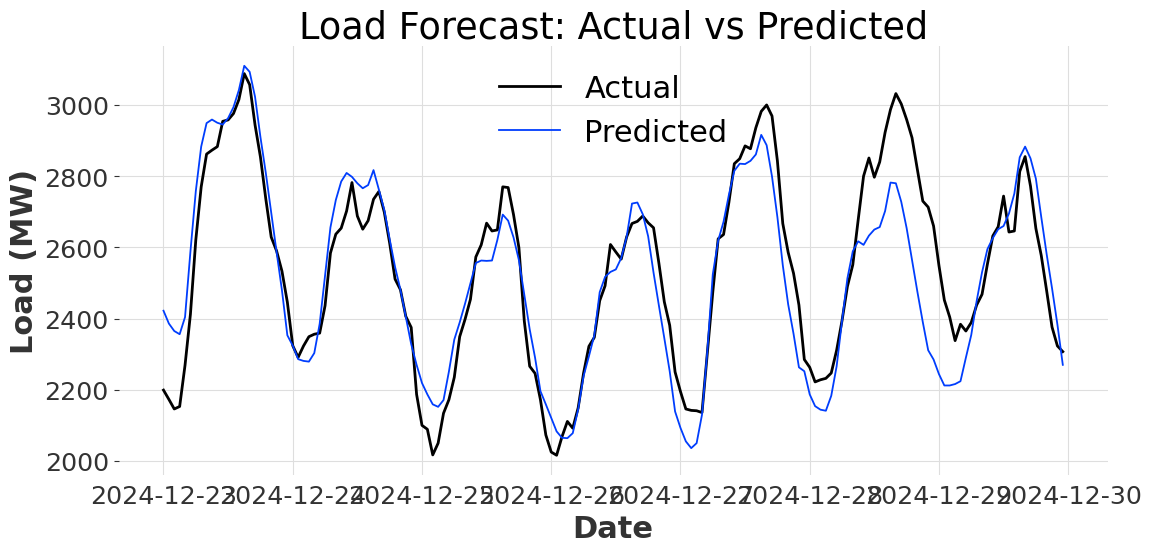

In [66]:
plot_forecast(actual_load_series, entsoe_forecast_series, 'ENTSO-E', 'ENTSO-E', False)

In [102]:
# Filter rows where the date is between Dec 20 and Dec 30 (inclusive)
dec_range = data[(data.index.month == 12) & (data.index.day >= 20) & (data.index.day <= 30)]

# Group by year and calculate the mean temperature
avg_temp_by_year = dec_range.groupby(dec_range.index.year)['Temperature'].mean()

# Display the result
print(avg_temp_by_year)

Time
2015    5.781722
2016    4.232051
2017    4.822414
2018    2.972603
2019    3.556278
2020    3.501626
2021   -1.375984
2022    3.772649
2023    3.374485
2024    5.049226
Name: Temperature, dtype: float64


In [104]:
print(future_data.head())

                     Actual Load  Temperature   Humidity  Solar  is_holiday  \
Time                                                                          
2015-01-01 00:00:00       2267.0     4.800586  86.225044    0.0           1   
2015-01-01 01:00:00       2281.0     3.931339  86.699943    0.0           1   
2015-01-01 02:00:00       2313.0     3.963989  85.319079    0.0           1   
2015-01-01 03:00:00       2372.0     4.079993  86.799788    0.0           1   
2015-01-01 04:00:00       2424.0     4.540231  85.029834    0.0           1   

                     hour  dayofweek  is_weekend  past_load  
Time                                                         
2015-01-01 00:00:00     0          3           0     2267.0  
2015-01-01 01:00:00     1          3           0     2281.0  
2015-01-01 02:00:00     2          3           0     2313.0  
2015-01-01 03:00:00     3          3           0     2372.0  
2015-01-01 04:00:00     4          3           0     2424.0  
